In [9]:
import os, sys, scipy
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test


input_path = '/fs/scratch/PCON0008/warner785/bwarner/gold_full/'
input_keyword = 'gold_st82_final'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]
print(gold_st82.size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Calling catalogs >>>
gold_st82_final_000056.fits
gold_st82_final_000003.fits
gold_st82_final_000026.fits
gold_st82_final_000121.fits
gold_st82_final_000094.fits
gold_st82_final_000040.fits
gold_st82_final_000010.fits
gold_st82_final_000082.fits
gold_st82_final_000068.fits
gold_st82_final_000075.fits
gold_st82_final_000103.fits
gold_st82_final_000112.fits
gold_st82_final_000043.fits
gold_st82_final_000125.fits
gold_st82_final_000083.fits
gold_st82_final_000101.fits
gold_st82_final_000016.fits
gold_st82_final_000031.fits
gold_st82_final_000041.fits
gold_st82_final_000052.fits
gold_st82_final_000092.fits
gold_st82_final_000027.fits
gold_st82_final_000127.fits
gold_st82_final_000095.fits
gold_st82_final_000114.fits
gold_st82_final_000079.fits
gold_st82_final_000045.fits
gold_st82_final_000086.fits
gold_st82_final_000007.fits
gold_st82_final_000029.fits
gold_st82_final_000055.fits
gold_st82_final_000076

In [10]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)

6860133
5752145


In [11]:
#this CMASS used for Y1, Y3:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

print(train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
61031


In [12]:
# find cmass in des_gold side --------------------
print(train_sample.size)
print(gold_st82.size)
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]


print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

61031
5752145
('num of cmass in des side', 60037, '(23%)')


In [13]:
#Figure 1 Start:

#import all necessary items from Su's code:
from xd import *
from utils import *
import esutil, yaml, sys, os, argparse
import healpy as hp
#from systematics import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import astropy.io.fits as fits

from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

In [16]:
#bring in photoObj file for this instead

train_sample = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]


print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))


#gold_train = gold_st82[cmass_mask]
clean_cmass_data_sdss = train_sample[mg1]           # common galaxies in cmass catalog
clean_cmass_data_des = gold_st82[mg2]        # common galaxies in Y1 Gold

gold_train = clean_cmass_data_des
cmass_train = clean_cmass_data_sdss
#print(cmass_train.dtype)
#print(cmass_train.size)
#No MODEL_MAG in matched cmass data: only MODELFLUX
#cmass_train = train_sample[cmass_mask]

('num of cmass in des side', 44045, '(17%)')


In [17]:
g_sdss = cmass_train['MODELMAG'][:,1]-cmass_train['EXTINCTION'][:,1]
r_sdss = cmass_train['MODELMAG'][:,2]-cmass_train['EXTINCTION'][:,2]
i_sdss = cmass_train['MODELMAG'][:,3]-cmass_train['EXTINCTION'][:,3]
gr_sdss = g_sdss - r_sdss
ri_sdss = r_sdss - i_sdss

gr_des = gold_train['MAG_DETMODEL_G']- gold_train['MAG_DETMODEL_R']
ri_des = gold_train['MAG_DETMODEL_R']- gold_train['MAG_DETMODEL_I']

gr_gold = gold_st82['MAG_DETMODEL_G']- gold_st82['MAG_DETMODEL_R']
ri_gold = gold_st82['MAG_DETMODEL_R']- gold_st82['MAG_DETMODEL_I']

In [18]:
x = np.linspace(-2,4,10)
dperp = 0.55 + x/8.

In [19]:
gr_sdss_err = np.sqrt(cmass_train['MODELMAGERR'][:,1]**2 + cmass_train['MODELMAGERR'][:,2]**2)
ri_sdss_err = np.sqrt(cmass_train['MODELMAGERR'][:,2]**2 + cmass_train['MODELMAGERR'][:,3]**2)

gr_des_err = np.sqrt(gold_train['MAGERR_DETMODEL_G']**2 +  gold_train['MAGERR_DETMODEL_R']**2 )
ri_des_err = np.sqrt(gold_train['MAGERR_DETMODEL_R']**2 +  gold_train['MAGERR_DETMODEL_I']**2 )

In [20]:
dperpcut = ((ri_sdss - gr_sdss/8. < 0.55) & 
((gr_sdss>0.5)&(gr_sdss<0.96)|
 ((gr_sdss>1.43)&(gr_sdss<1.435))|
 ((gr_sdss>1.85)&(gr_sdss<3.0)) ) )

dperpcut_des = (ri_des - gr_des/8. < 0.5505) & (ri_des - gr_des/8. > 0.55035)
print(np.sum(dperpcut), np.sum(dperpcut_des))

0 17


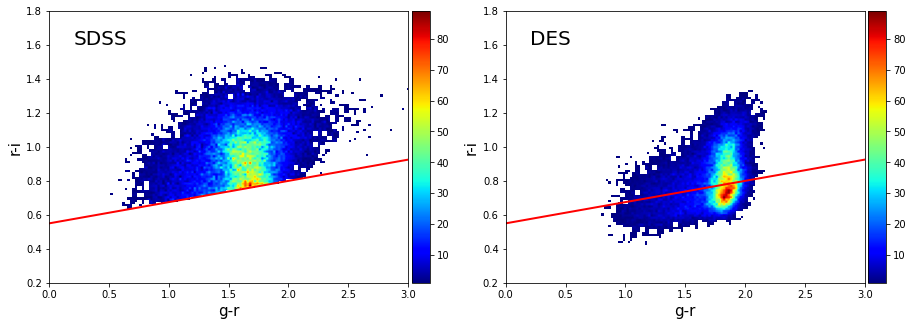

In [21]:
#Su's recommendation:

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

xbins = np.linspace(0, 3.0, 150)
ybins = np.linspace(0.2, 1.8, 120)
Ngal_sdss, xedges, yedges = np.histogram2d(gr_sdss, ri_sdss, bins=(xbins, ybins))
Ngal_des, xedges, yedges = np.histogram2d(gr_des, ri_des, bins=(xbins, ybins))

Ngal_sdss[Ngal_sdss == 0] = np.nan
Ngal_des[Ngal_des == 0] = np.nan

# plot
fig, (ax,ax2) = plt.subplots(1,2,figsize=(15,5))

ax.imshow(np.rot90(Ngal_sdss), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=cm.jet, aspect='auto')#, 

ax.plot(x, dperp, 'r-', linewidth=2)
pos1=ax.imshow(np.rot90(Ngal_sdss), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=cm.jet, aspect='auto')
#fig.colorbar(pos1, ax=ax)

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pos1, cax=cax1)

ax.text(0.2, 1.6, 'SDSS', fontsize=20)
ax.set_xlabel('g-r', fontsize=15)
ax.set_ylabel('r-i', fontsize=15)
ax.set_xlim(0,3.)
ax.set_ylim(0.2,1.8)

ax2.imshow(np.rot90(Ngal_des), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=cm.jet, aspect='auto'  )#, 
#cbar = fig.colorbar(im, ax=ax)
#cbar.set_label(r'$N_{\rm gal}$', fontsize=15)

ax2.plot(x, dperp, 'r-', linewidth = 2)
#ax2.errorbar( gr_des[dperpcut], ri_des[dperpcut], xerr = gr_des_err[dperpcut], 
#            yerr = ri_des_err[dperpcut], fmt = '.', color='black', zorder=10)
ax2.text(0.2, 1.6, 'DES', fontsize=20)
ax2.set_xlabel('g-r', fontsize=15)
ax2.set_ylabel('r-i', fontsize=15)
ax2.set_xlim(0,3.)
ax2.set_ylim(0.2,1.8)
pos2=ax2.imshow(np.rot90(Ngal_des), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=cm.jet, aspect='auto'  )

#contour??

import seaborn as sns

data_gold = np.column_stack( [gr_gold, ri_gold] )

#df = sns.load_dataset('data_gold')
#sns.set_style("white")
#sns.kdeplot(x=gr_gold, y=ri_gold, cmap="Reds", shade=True, bw_adjust=.5)
#plt.show()

#fig.colorbar(pos2, ax=ax2)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pos1, cax=cax2)

#cbar2.set_label(r'$N_{\rm gal}$')
plt.savefig('Y3Figure1progress.png')

#plots inline? --google
plt.show()
#next-- making contours
#coutour2D
#seaborn
#upload to git

In [ ]:
## NEXT: creating the contour plots

In [ ]:
from run_DMASS import *

cutmask = priorCut_test(gold_st82)
gold_cut_outlier = gold_st82[cutmask]

In [ ]:
#dperp_des = ri_des - gr_des/8.

gr_gold = gold_cut_outlier['MAG_DETMODEL_G']- gold_cut_outlier['MAG_DETMODEL_R']
ri_gold = gold_cut_outlier['MAG_DETMODEL_R']- gold_cut_outlier['MAG_DETMODEL_I']
dperp_gold = ri_gold - gr_gold/8.

In [ ]:
Ncmass = []
Nall = []
for dp in np.linspace(0.3, 0.6, 31):
    dpmask = dperp_gold > dp
    gold_train, cmass_train = matchCatalogsbyPosition(gold_cut_outlier[dpmask], cmass_stripe)
    Ncmass.append(gold_train.size)
    Nall.append(gold_cut_outlier[dpmask].size)
    print dp, gold_train.size, gold_cut_outlier[dpmask].size

In [ ]:
ncmass = np.array(Ncmass) * 1./np.array(Nall)
Nno = np.array(Nall) - np.array(Ncmass)

In [ ]:
fig, ax = plt.subplots()
ax.plot( np.linspace(0.3, 0.6, 31), ncmass*1./ncmass.max() )
ax.plot( np.linspace(0.3, 0.6, 31), Nno *1./np.array(Nall)  )
ax.axvline(x = 0.55, ls='--', color='k')

In [ ]:
def mixing_SDSS_color(data, suffix = '', sdss = None, cmass = None ):
    
    #filter = ['G', 'R', 'I', 'Z']
    filter = [1,2,3,4]
    mag = ['CMODELMAG', 'MODELMAG']
    magtag = mag#[ m+'_'+f+suffix for m in mag for f in filter ]
    #del magtag[0], magtag[2]
    err = [ 'CMODELMAGERR','MODELMAGERR']
    errtag = err#[ e+'_'+f for e in err for f in filter ]
    #del errtag[0], errtag[2]
    
    
    print data['CMODELMAG'][:,0].size
    
    X = [ data[mt][:,i] for mt in magtag for i in filter ]
    del X[0], X[2]
    Xerr = [ data[mt][:,i] for mt in errtag for i in filter]
    del Xerr[0], Xerr[2]
    #reddeningtag = 'XCORR_SFD98'

    X = np.vstack(X).T
    Xerr = np.vstack(Xerr).T
    # mixing matrix
    W = np.array([
                  [1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],    # i cmag
                  [0, 0, 1, -1, 0, 0],   # g-r
                  [0, 0, 0, 1, -1, 0],   # r-i
                  [0, 0, 0, 0, 1, -1]])  # i-z

    X = np.dot(X, W.T)

    Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
    Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr**2
    Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))
    return X, Xcov

In [ ]:
X_cmass_train, Xcov_cmass_train = mixing_SDSS_color(cmass_train)

In [ ]:
X_cmass_train_new = [np.random.multivariate_normal( X_cmass_train[i], Xcov_cmass_train[i], 1 ) for i in range(cmass_train.size) ]

In [ ]:
X_cmass_train_new = np.array(X_cmass_train_new)

In [ ]:
new_gr_sdss = X_cmass_train_new[:,0][:,2]
new_ri_sdss = X_cmass_train_new[:,0][:,3]

In [ ]:
xbins = np.linspace(0, 3.0, 150)
ybins = np.linspace(0.2, 1.8, 120)
Ngal_sdss, xedges, yedges = np.histogram2d(gr_sdss, ri_sdss, bins=(xbins, ybins), normed=False)
Ngal_des, xedges, yedges = np.histogram2d(gr_des, ri_des, bins=(xbins, ybins), normed=False)

Ngal_sdss[Ngal_sdss == 0] = np.nan
Ngal_des[Ngal_des == 0] = np.nan

In [ ]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

dat = data_gold.copy()
dat[:,0] = dat[:,0]+10
dat[:,1] = dat[:,1]+10
c.add_chain(dat, parameters=["$g-r$", "$r-i$"])
#c.add_chain(data_des)
c.configure(plot_hists=False, cloud=False, sigmas=np.linspace(0, 3, 10), colors ='grey', 
            shade_alpha = 0.5, kde=False)


fig = c.plotter.plot(figsize=(4,3.2))
ax = fig.axes[0]

im = ax.imshow(np.rot90(Ngal_sdss), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=plt.cm.jet, aspect='auto', zorder = 2 )#, 
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$N_{\rm gal}$', fontsize=15)
ax.plot(x, dperp, 'r-', linewidth=1, zorder = 3)

#ax.errorbar( gr_sdss[dperpcut], ri_sdss[dperpcut], xerr = gr_sdss_err[dperpcut], 
#            yerr = ri_sdss_err[dperpcut], fmt = 'o', color='black', zorder=10)


ax.set_xlabel('g-r', fontsize=15)
ax.set_ylabel('r-i', fontsize=15)
ax.set_xlim(0,3.)
ax.set_ylim(0.2,1.8)

ax.text(1.9, 0.3, 'SDSS  Color' )
plt.tight_layout()

fig.savefig('../paper_figure/gri_sdss_color_cbar.pdf')

In [ ]:
from chainconsumer import ChainConsumer

#seed(0)
#cov = normal(size=(3, 3))
#data = multivariate_normal(normal(size=3), np.dot(cov, cov.T), size=100000)

data_gold = np.column_stack( [gr_gold, ri_gold] )
data_sdss = np.column_stack( [gr_sdss, ri_sdss] )
data_des = np.column_stack( [gr_des, ri_des] )

c = ChainConsumer()
c.add_chain(data_gold, parameters=["$g-r$", "$r-i$"])
#c.add_chain(data_des)
c.configure(plot_hists=False, cloud=True, sigmas=np.linspace(0, 3, 10), colors ='grey', 
            shade_alpha = 0.7, kde=False)


fig = c.plotter.plot(figsize=(4,3.2))
ax = fig.axes[0]

ax.imshow(np.rot90(Ngal_des), extent=(np.amin(xbins), np.amax(xbins), np.amin(ybins), np.amax(ybins)),
        cmap=plt.cm.jet, aspect='auto', zorder = 2, alpha = 1.0 )#, 
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$N_{\rm gal}$', fontsize=15)
ax.plot(x, dperp, 'r-', linewidth=1, zorder = 3)

#ax.errorbar( gr_sdss[dperpcut], ri_sdss[dperpcut], xerr = gr_sdss_err[dperpcut], 
#            yerr = ri_sdss_err[dperpcut], fmt = 'o', color='black', zorder=10)


ax.set_xlabel('g-r', fontsize=15)
ax.set_ylabel('r-i', fontsize=15)
ax.set_xlim(0,3.)
ax.set_ylim(0.2,1.8)

ax.text(2.0, 0.3, 'DES  Color')
plt.tight_layout()

fig.savefig('../paper_figure/gri_des_color_cbar.pdf')